In [1]:
import warp
import jax.numpy as jnp
import jax.random as jrng
import matplotlib.pyplot as plt

we start with a regular grid with 4 pixel spacing between points

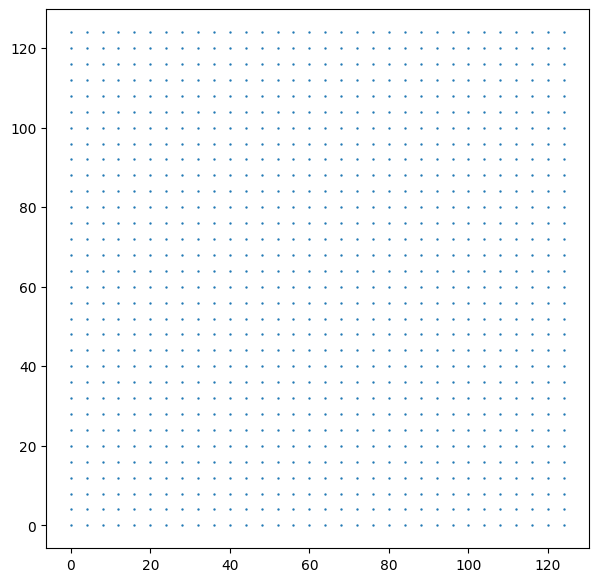

In [2]:
L = 128
X, Y = jnp.meshgrid( jnp.arange(0, L, 4), jnp.arange(0, L, 4) )
control = jnp.stack((X.flatten(), Y.flatten()), axis=-1)

plt.figure(figsize=(7, 7))
plt.scatter(*control.T, s=0.5)
plt.axis('equal')
plt.show()

now we generate a random distortion. note that we need to provide length scales (`L`)

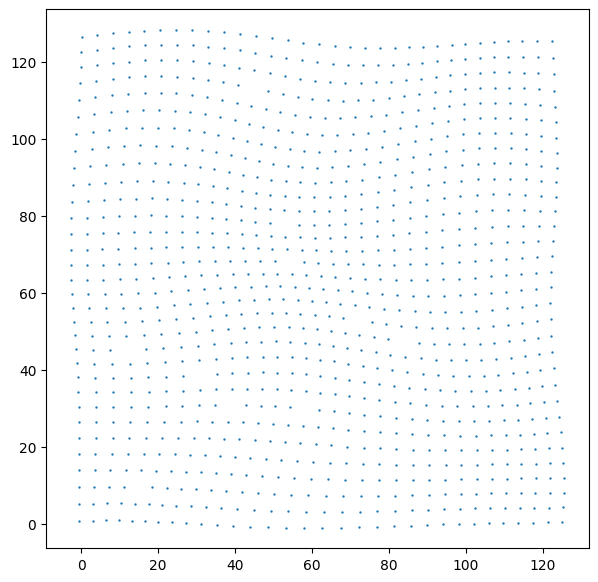

In [3]:
theta_true = 0.5 * jrng.normal(jrng.PRNGKey(0), shape=(2, 49))
w_true = warp.Warp(scales=(L, L), theta_0=theta_true)
target = w_true.transform(control)

# delete a couple from the targets
to_del = jrng.choice(jrng.PRNGKey(0), len(target), shape=(10,))
for i in sorted(to_del)[::-1]:
    target = jnp.concat(( target[:i], target[i + 1:] ))

plt.figure(figsize=(7, 7))
plt.scatter(*target.T, s=0.5)
plt.axis('equal')
plt.show()

we can optionally apply weights to the control and/or target points. I'm choosing to do a simple radial weighting from the image center

[87.681244 84.89994  82.219215 ... 82.219215 84.89994  87.681244]


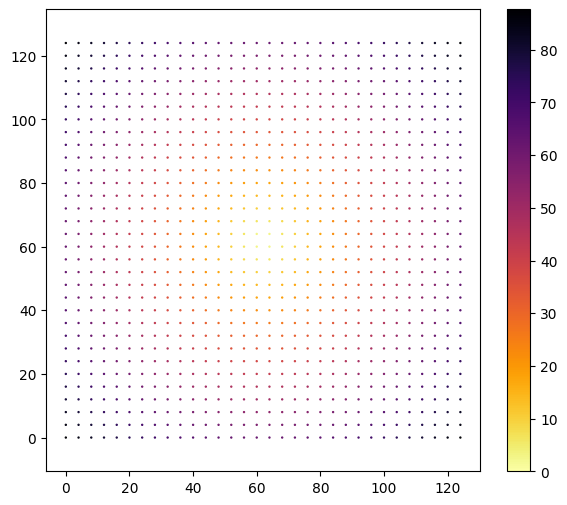

[87.681244 84.89994  82.219215 ... 82.219215 84.89994  87.681244]


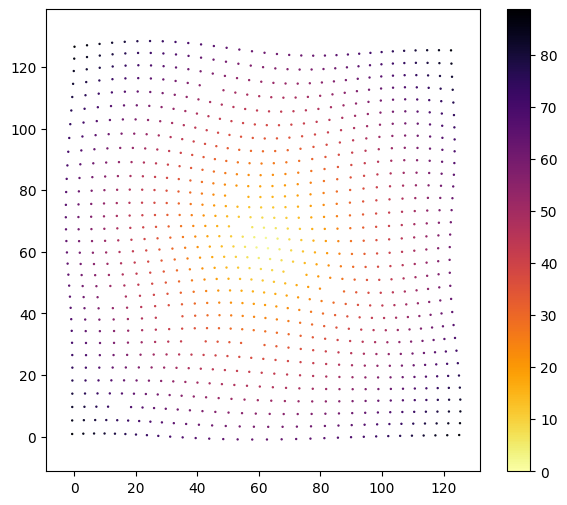

In [4]:
com = jnp.mean(control, axis=0)
wgt_c = jnp.linalg.norm(control - com, axis=-1)
print(wgt_c)

plt.figure(figsize=(7, 6))
plt.scatter(*control.T, s=0.5, c=wgt_c, cmap='inferno_r', vmin=0)
plt.axis('equal')
plt.colorbar()
plt.show()


com = jnp.mean(target, axis=0)
wgt_t = jnp.linalg.norm(target - com, axis=-1)
print(wgt_c)

plt.figure(figsize=(7, 6))
plt.scatter(*target.T, s=0.5, c=wgt_t, cmap='inferno_r', vmin=0)
plt.axis('equal')
plt.colorbar()
plt.show()

here's how to actually do the fitting. make a `Warp` object, specifying kwargs to customize the training (again note that the scales are required). then run its `.fit()` method with the control and target points and their weights

fitting:   0%|          | 0/500 [00:00<?, ?epoch/s]

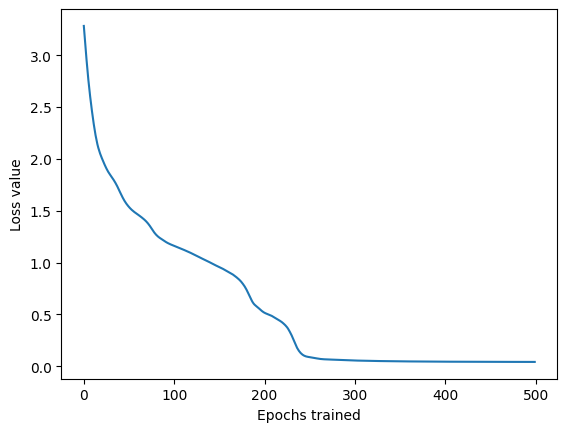

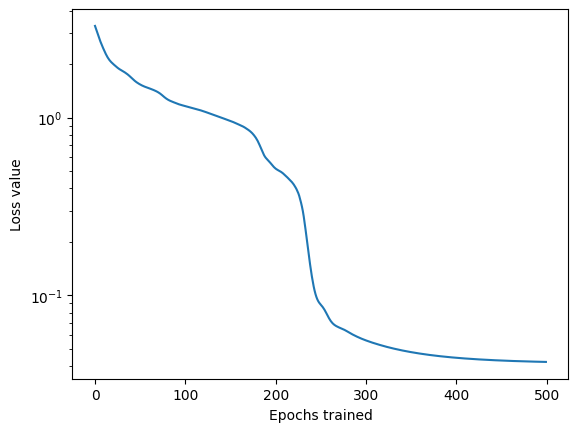

In [5]:
w = warp.Warp(scales=(L, L), theta_0=None, auto_refine=False, lr=1e-2, max_iter=500, cap=5, alpha=0.1)
w.fit(control, target, weights_c=wgt_c, weights_t=wgt_t)

plt.plot(w.loss_curve_)
plt.xlabel('Epochs trained')
plt.ylabel('Loss value')
plt.show()

plt.plot(w.loss_curve_)
plt.xlabel('Epochs trained')
plt.ylabel('Loss value')
plt.yscale('log')
plt.show()

with a trained `Warp`, we can apply the warp to whatever points we want using its `.transform` method. here I also compute the distance from each model point to the closest target point for the colormap

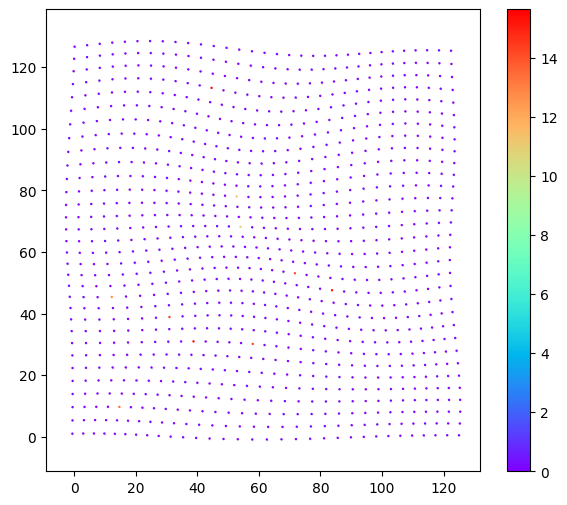

In [6]:
model = w.transform(control)
mse = jnp.square(target[None, :, :] - model[:, None, :]).sum(-1).min(-1)

from matplotlib.colors import LogNorm

plt.figure(figsize=(7, 6))
plt.scatter(*target.T, s=0.5, color='k', alpha=0.1)
plt.scatter(*model.T, s=0.5, c=mse, cmap='rainbow', vmin=0)
plt.axis('equal')
plt.colorbar()
plt.show()

during training, the `Warp` object saves all of the intermediate values of the parameters, allowing us to iterate over them and analyze the performance as a function of train time. for one fun example, here I plot the distorted control points as a function of time, so we can see them smoothly move onto the targets.

In [7]:
import tempfile
from PIL import Image
from os.path import join
from tqdm.auto import tqdm

tmp = tempfile.gettempdir()
frames = []

_w = warp.Warp(scales=(L, L))
distort = _w._distort_factory(control)

for i, theta in enumerate(tqdm(w.thetas_, desc="rendering")):
    _model = distort(theta)
    _mse = jnp.square(target[None, :, :] - _model[:, None, :]).sum(-1).min(-1)

    _filename = join(tmp, f"frame_{i}.png")
    
    plt.figure(figsize=(7, 6))
    plt.scatter(*target.T, s=0.5, color='k', alpha=0.1)
    plt.scatter(*_model.T, s=0.5, c=_mse, cmap='rainbow', vmin=0)
    plt.axis('equal')
    plt.title(f'Epoch {i}')
    plt.colorbar()
    plt.savefig(_filename)
    plt.close()

    frames.append(Image.open(_filename))

frames[0].save("training.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)

rendering:   0%|          | 0/501 [00:00<?, ?it/s]

we can also do a `lstsq` refinement of the fit parameters, once the warp is good enough that the closest targets are the correct ones.

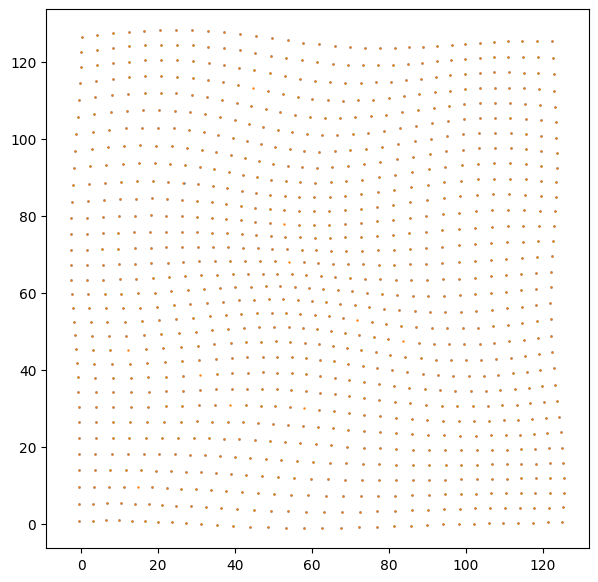

In [8]:
w.refine(control, target)
model_ref = w.transform(control)

plt.figure(figsize=(7, 7))
plt.scatter(*target.T, s=0.5)
plt.scatter(*model_ref.T, s=0.5)
plt.axis('equal')
plt.show()